In [116]:
# N-BEATS model for Cherry Blossom Bloom Day (pytorch-forecasting)
# This notebook mirrors the TFT/SARIMA/Prophet flows: same splits, metrics, and plots.


In [117]:
import warnings
warnings.filterwarnings('ignore')

import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

# safe imports for pytorch-forecasting and lightning
HAS_PF = True
try:
    pf = importlib.import_module('pytorch_forecasting')
    TimeSeriesDataSet = getattr(pf, 'TimeSeriesDataSet')
    # try possible N-BEATS module names
    try:
        nb_mod = importlib.import_module('pytorch_forecasting.models.nbeats')
        NBeats = getattr(nb_mod, 'NBeats')
    except Exception:
        try:
            nb_mod = importlib.import_module('pytorch_forecasting.models.n_beats')
            NBeats = getattr(nb_mod, 'NBeats')
        except Exception:
            # fallback to generic models module
            nb_mod = importlib.import_module('pytorch_forecasting.models')
            NBeats = getattr(nb_mod, 'NBeats', None)
    if NBeats is None:
        raise ImportError('NBeats model not found in pytorch_forecasting')
    pf_metrics = importlib.import_module('pytorch_forecasting.metrics')
    QuantileLoss = getattr(pf_metrics, 'QuantileLoss')
    pf_data = importlib.import_module('pytorch_forecasting.data')
    GroupNormalizer = getattr(pf_data, 'GroupNormalizer')
except Exception:
    HAS_PF = False
    TimeSeriesDataSet = None
    NBeats = None
    QuantileLoss = None
    GroupNormalizer = None

# import lightning namespace robustly
try:
    try:
        pl = importlib.import_module('lightning.pytorch')
    except Exception:
        pl = importlib.import_module('pytorch_lightning')
    callbacks_mod = importlib.import_module(pl.__name__ + '.callbacks')
    EarlyStopping = getattr(callbacks_mod, 'EarlyStopping')
    ModelCheckpoint = getattr(callbacks_mod, 'ModelCheckpoint')
except Exception:
    pl = None
    EarlyStopping = None
    ModelCheckpoint = None

from sklearn.metrics import mean_squared_error, mean_absolute_error


In [118]:
# 1) Load data
DATA_PATH = '../data/cherry_blossom_data.csv'
df = pd.read_csv(DATA_PATH)
print('Loaded rows:', len(df))
# ensure numeric
numeric_cols = ['days_dec_ge_45','days_jan_ge_45','days_feb_ge_45','prec_winter',
                'mean_temp_winter','surface_temp_chg','climate_incidents']
for c in numeric_cols + ['bloom_day','year']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# keep first duplicate years if any
df = df.sort_values('year').reset_index(drop=True)
df = df.drop_duplicates(subset=['year'], keep='first').reset_index(drop=True)

# drop incomplete rows for essential features
df = df.dropna(subset=['year','bloom_day']).reset_index(drop=True)

# create time_idx
df['time_idx'] = (df['year'] - df['year'].min()).astype(int)
# single series id
df['series'] = 'cherry_blossom'


Loaded rows: 105


In [119]:
# 2) Splits
train_val_df = df[(df['year'] >= 1921) & (df['year'] <= 2015)].sort_values('time_idx').reset_index(drop=True)
test_df = df[(df['year'] >= 2016) & (df['year'] <= 2025)].sort_values('time_idx').reset_index(drop=True)

if len(train_val_df) == 0:
    raise ValueError('No data available in 1921-2015 to train/validate on')

train_val_size = len(train_val_df)
train_n = int(np.floor(train_val_size * 0.8))
train_df = train_val_df.iloc[:train_n].reset_index(drop=True)
val_df = train_val_df.iloc[train_n:].reset_index(drop=True)

print(f'Train rows: {len(train_df)}, Val rows: {len(val_df)}, Test rows: {len(test_df)}')


Train rows: 76, Val rows: 19, Test rows: 10


In [120]:
# 3) Build TimeSeriesDataSet (same structure as TFT)
if not HAS_PF or GroupNormalizer is None or TimeSeriesDataSet is None:
    raise ImportError('pytorch-forecasting is required for the NBeats notebook. Install with: pip install pytorch-forecasting')

FEATURES = numeric_cols
TARGET = 'bloom_day'

# Use a fixed encoder length required by N-BEATS (min_encoder_length == max_encoder_length)
max_encoder_length = min(30, len(train_df))
fixed_encoder_length = max(1, max_encoder_length)  # ensure at least 1
fixed_prediction_length = 1

training = TimeSeriesDataSet(
    train_df,
    time_idx='time_idx',
    target=TARGET,
    group_ids=['series'],
    # fixed encoder/prediction lengths (required by N-BEATS)
    min_encoder_length=fixed_encoder_length,
    max_encoder_length=fixed_encoder_length,
    min_prediction_length=fixed_prediction_length,
    max_prediction_length=fixed_prediction_length,
    # N-BEATS expects a pure univariate setup: only the target as time-varying unknown real
    time_varying_known_reals=[],
    time_varying_unknown_reals=[TARGET],
    # ensure no categoricals or static reals are present for the adapter
    time_varying_known_categoricals=[],
    time_varying_unknown_categoricals=[],
    static_categoricals=[],
    static_reals=[],
    # N-BEATS adapter requires no relative time index
    add_relative_time_idx=False,
    target_normalizer=GroupNormalizer(groups=['series']),
    # ensure deterministic lengths
    randomize_length=None,
)

# construct validation dataset using the same fixed lengths
# If val_df is too short to contain full encoder windows, prepend the last `max_encoder_length` rows from train_df
pre_history_len = int(training.max_encoder_length)
if len(train_df) >= pre_history_len and len(val_df) < pre_history_len + 1:
    pre_history = train_df.tail(pre_history_len).copy()
    # ensure time_idx continuity
    val_with_history = pd.concat([pre_history, val_df], ignore_index=True)
else:
    # if val_df already has enough history or train_df is small, just use val_df
    val_with_history = val_df.copy()

validation = TimeSeriesDataSet.from_dataset(
    training,
    val_with_history,
    stop_randomization=True,
    allow_missing_timesteps=True,
    # use fixed encoder/prediction lengths equal to the training dataset to avoid variable-length val sequences
    min_encoder_length=training.max_encoder_length,
    max_encoder_length=training.max_encoder_length,
    min_prediction_length=training.max_prediction_length,
    max_prediction_length=training.max_prediction_length,
    randomize_length=None,
)

train_dataloader = training.to_dataloader(train=True, batch_size=16, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=16, num_workers=0)


In [121]:
# 4) Configure and train N-BEATS
if pl is None or EarlyStopping is None or ModelCheckpoint is None:
    raise ImportError('pytorch-lightning is required for the NBeats notebook. Install with: pip install pytorch-lightning')
pl.seed_everything(42)

# build a small NBeats model (keep small for speed)
if NBeats is None:
    raise ImportError('NBeats model class not available in your pytorch-forecasting installation')

# ensure we pass matching input/output lengths to the model (different PF versions accept different kwarg names)

# --- robust N-BEATS instantiation: inspect a real batch and align model lengths ---
enc_len = int(training.max_encoder_length)
pred_len = int(training.max_prediction_length)
print('Dataset configured encoder length =', enc_len, 'prediction length =', pred_len)

# helper: recursively collect plausible time-dimension candidates from a batch
def find_encoder_length_from_batch(batch, max_expected=None):
    import torch, numpy as _np
    from collections import Counter

    # First, try explicit keys that reliably contain encoder length
    def try_explicit(batch):
        # if batch is dict
        if isinstance(batch, dict):
            if 'encoder_target' in batch:
                val = batch['encoder_target']
                if hasattr(val, 'shape') and len(val.shape) >= 2:
                    return int(val.shape[1])
            if 'encoder_lengths' in batch:
                val = batch['encoder_lengths']
                try:
                    # encoder_lengths is often [batch]
                    return int(val[0])
                except Exception:
                    pass
            # nested dicts
            for v in batch.values():
                res = try_explicit(v)
                if res is not None:
                    return res
            return None
        # if batch is list/tuple, inspect first element(s)
        if isinstance(batch, (list, tuple)):
            for elem in batch[:3]:
                res = try_explicit(elem)
                if res is not None:
                    return res
        return None

    explicit = try_explicit(batch)
    if explicit is not None:
        print('Found explicit encoder length via encoder_target/encoder_lengths:', explicit)
        return explicit

    # Fallback: recursively collect plausible time-dimension candidates from tensors / arrays / nested lists
    candidates = []
    def collect(x, depth=0):
        if depth > 8:
            return
        # torch tensors
        try:
            if torch.is_tensor(x):
                s = x.shape
                # plausible axes: second dim, third dim, last dim
                if len(s) >= 2:
                    candidates.append(int(s[1]))
                if len(s) >= 3:
                    candidates.append(int(s[2]))
                if len(s) >= 1:
                    candidates.append(int(s[-1]))
                return
        except Exception:
            pass
        # numpy arrays
        if isinstance(x, _np.ndarray):
            s = x.shape
            if len(s) >= 2:
                candidates.append(int(s[1]))
            if len(s) >= 3:
                candidates.append(int(s[2]))
            if len(s) >= 1:
                candidates.append(int(s[-1]))
            return
        # pandas
        try:
            import pandas as pd
            if isinstance(x, pd.Series) or isinstance(x, pd.DataFrame):
                arr = x.to_numpy()
                if arr.ndim >= 2:
                    candidates.append(int(arr.shape[1]))
                return
        except Exception:
            pass
        # dict/list/tuple: recurse
        if isinstance(x, dict):
            for v in x.values():
                collect(v, depth+1)
            return
        if isinstance(x, (list, tuple)):
            # inspect first few elements to avoid deep recursion
            for i, v in enumerate(x[:4]):
                collect(v, depth+1)
            return
        return

    collect(batch)
    # normalize and filter
    candidates = [int(c) for c in candidates if isinstance(c, (int,)) and c > 0]
    print('Collected encoder-dim candidates from batch:', candidates)
    if not candidates:
        return None
    cnt = Counter(candidates)
    # prefer values <= max_expected
    if max_expected is not None:
        # prefer the largest candidate that is <= max_expected (likely the true encoder length)
        valid_dims = sorted({d for d in candidates if d <= max_expected})
        if valid_dims:
            chosen = int(max(valid_dims))
            print('Chosen encoder length (max <= max_expected):', chosen)
            return chosen
    # fallback: most common
    return int(cnt.most_common(1)[0][0])

# instantiate model preferring the kwarg style that works in this PF version
# (we'll try to use context_length/prediction_length because that's what worked earlier)
try:
    # try to sample a single real batch and detect encoder length
    try:
        sample_batch = next(iter(train_dataloader))
        print('Sampled one batch of type:', type(sample_batch))
        # optional: show a compact structure summary for debugging
        def print_batch(x, prefix=''):
            import torch
            if isinstance(x, dict):
                print(prefix + 'dict keys:', list(x.keys()))
                for k, v in x.items():
                    print(prefix + f'  {k}: type={type(v)}, shape={getattr(v, "shape", None)}')
            elif isinstance(x, (list, tuple)):
                print(prefix + f'{type(x).__name__} len={len(x)}')
                for i, v in enumerate(x[:4]):
                    print(prefix + f'  elem[{i}] type={type(v)}, shape={getattr(v, "shape", None)}')
                    if isinstance(v, dict):
                        for kk, vv in v.items():
                            print(prefix + f'    {kk}: shape={getattr(vv, "shape", None)}')
            else:
                print(prefix + f'object type={type(x)}, shape={getattr(x, "shape", None)}')
        print_batch(sample_batch)
    except Exception as e:
        print('Could not sample a batch for inspection:', e)
        sample_batch = None

    sample_enc_len = find_encoder_length_from_batch(sample_batch, max_expected=enc_len) if sample_batch is not None else None
    if sample_enc_len is None:
        print('Could not deduce encoder length from batch; using dataset encoder length:', enc_len)
        sample_enc_len = enc_len
    else:
        print('Detected encoder length from batch:', sample_enc_len)

    # --- ENSURE MODEL USES THE DATASET ENCODER LENGTH TO AVOID MISMATCHS ---
    # Force context_length to dataset-configured encoder length to be deterministic
    sample_enc_len = enc_len

    # create NBeats with the detected context length (this PF version uses context_length/prediction_length)
    create_kwargs = dict(context_length=sample_enc_len, prediction_length=pred_len, learning_rate=0.03, log_interval=10, log_val_interval=1, weight_decay=1e-6)
    print('Creating NBeats with kwargs:', create_kwargs)
    nbeats = NBeats.from_dataset(training, **create_kwargs)
    print('NBeats created; model summary below:')
    try:
        print(nbeats)  # concise summary
    except Exception:
        pass

    # --- VALIDATION: ensure model's first Linear in_features matches dataset encoder length ---
    try:
        first_linear_in = None
        for module in nbeats.net_blocks.modules():
            if isinstance(module, torch.nn.Linear):
                first_linear_in = int(module.in_features)
                break
        print('Model first Linear.in_features =', first_linear_in, 'training.max_encoder_length =', int(training.max_encoder_length))
        if first_linear_in is not None and first_linear_in != int(training.max_encoder_length):
            raise RuntimeError(f'Model expects input length {first_linear_in} but dataset provides {int(training.max_encoder_length)}. Recreate model/dataset to align lengths.')
    except Exception:
        import traceback
        print('Validation failed (see traceback):')
        traceback.print_exc()
        raise

except Exception:
    import traceback
    traceback.print_exc()
    raise
# --- end robust instantiation cell ---

Seed set to 42


Dataset configured encoder length = 30 prediction length = 1
Sampled one batch of type: <class 'tuple'>
tuple len=2
  elem[0] type=<class 'dict'>, shape=None
    encoder_cat: shape=torch.Size([16, 30, 0])
    encoder_cont: shape=torch.Size([16, 30, 1])
    encoder_target: shape=torch.Size([16, 30])
    encoder_lengths: shape=torch.Size([16])
    decoder_cat: shape=torch.Size([16, 1, 0])
    decoder_cont: shape=torch.Size([16, 1, 1])
    decoder_target: shape=torch.Size([16, 1])
    decoder_lengths: shape=torch.Size([16])
    decoder_time_idx: shape=torch.Size([16, 1])
    groups: shape=torch.Size([16, 1])
    target_scale: shape=torch.Size([16, 2])
  elem[1] type=<class 'tuple'>, shape=None
Found explicit encoder length via encoder_target/encoder_lengths: 30
Detected encoder length from batch: 30
Creating NBeats with kwargs: {'context_length': 30, 'prediction_length': 1, 'learning_rate': 0.03, 'log_interval': 10, 'log_val_interval': 1, 'weight_decay': 1e-06}
NBeats created; model summa

In [122]:
# # 4) Configure and train N-BEATS
# if pl is None or EarlyStopping is None or ModelCheckpoint is None:
#     raise ImportError('pytorch-lightning is required for the NBeats notebook. Install with: pip install pytorch-lightning')
# pl.seed_everything(42)
#
# # build a small NBeats model (keep small for speed)
# if NBeats is None:
#     raise ImportError('NBeats model class not available in your pytorch-forecasting installation')
#
# # ensure we pass matching input/output lengths to the model (different PF versions accept different kwarg names)
# enc_len = int(training.max_encoder_length)
# pred_len = int(training.max_prediction_length)
# print('Using encoder length =', enc_len, 'prediction length =', pred_len)
#
# candidate_kwargs = [
#     {'backcast_length': enc_len, 'forecast_length': pred_len},
#     {'input_chunk_length': enc_len, 'output_chunk_length': pred_len},
#     {'context_length': enc_len, 'prediction_length': pred_len},
# ]
#
# # helper to extract encoder length from a batch (handles dict/tuple/list)
# def extract_encoder_length_from_batch(batch, max_expected=None):
#     import torch
#     import numpy as _np
#     from collections import Counter
#
#     # recursively collect plausible time-dimension sizes from tensors / arrays / nested lists
#     candidates = []
#     def collect(x, depth=0):
#         if depth > 8:
#             return
#         # torch tensor
#         if torch.is_tensor(x):
#             s = x.shape
#             # consider several plausible axes for time dimension
#             if len(s) >= 2:
#                 candidates.append(int(s[1]))
#             if len(s) >= 3:
#                 candidates.append(int(s[2]))
#             # last axis as a fallback
#             if len(s) >= 2:
#                 candidates.append(int(s[-1]))
#             return
#         # numpy array
#         if isinstance(x, _np.ndarray):
#             s = x.shape
#             if len(s) >= 2:
#                 candidates.append(int(s[1]))
#             if len(s) >= 3:
#                 candidates.append(int(s[2]))
#             if len(s) >= 2:
#                 candidates.append(int(s[-1]))
#             return
#         # pandas Series/DataFrame
#         try:
#             import pandas as pd
#             if isinstance(x, pd.Series):
#                 arr = x.to_numpy()
#                 if arr.ndim >= 2:
#                     candidates.append(int(arr.shape[1]))
#                 return
#             if isinstance(x, pd.DataFrame):
#                 arr = x.to_numpy()
#                 if arr.ndim >= 2:
#                     candidates.append(int(arr.shape[1]))
#                 return
#         except Exception:
#             pass
#         # dict
#         if isinstance(x, dict):
#             for v in x.values():
#                 collect(v, depth+1)
#             return
#         # list/tuple: inspect first few elements
#         if isinstance(x, (list, tuple)):
#             for i, v in enumerate(x[:3]):
#                 collect(v, depth+1)
#             return
#         return
#
#     collect(batch)
#     # normalize candidate values (filter non-positive)
#     candidates = [int(c) for c in candidates if isinstance(c, (int,)) and c > 0]
#     print('Collected encoder-dim candidates:', candidates)
#     if not candidates:
#         return None
#     cnt = Counter(candidates)
#     # prefer candidates <= max_expected (if provided), then most common
#     if max_expected is not None:
#         valid = [(d, cnt[d]) for d in cnt if d <= max_expected]
#         if valid:
#             valid.sort(key=lambda x: (x[1], x[0]), reverse=True)
#             chosen = valid[0][0]
#             print('Chosen encoder length (<=max_expected):', chosen)
#             return int(chosen)
#     most_common = cnt.most_common(1)[0][0]
#     print('Chosen encoder length (most common):', most_common)
#     return int(most_common)
#
# # Try to instantiate NBeats and then validate against a sampled batch
# nbeats = None
# used_kwargs = None
# create_errors = []
# for kw in candidate_kwargs:
#     try:
#         print('Trying NBeats.from_dataset with kwargs:', kw)
#         nbeats = NBeats.from_dataset(
#             training,
#             learning_rate=0.03,
#             log_interval=10,
#             log_val_interval=1,
#             weight_decay=1e-6,
#             **kw,
#         )
#         print('NBeats created successfully with kwargs:', kw)
#         used_kwargs = kw
#         break
#     except Exception as e:
#         import traceback
#         print('Failed to create NBeats with kwargs:', kw)
#         traceback.print_exc()
#         create_errors.append((kw, e))
#
# if nbeats is None:
#     print('Tried kwargs and failed; dataset summary:')
#     print(' training.max_encoder_length=', getattr(training, 'max_encoder_length', None))
#     print(' training.max_prediction_length=', getattr(training, 'max_prediction_length', None))
#     print(' training.reals=', getattr(training, 'reals', None))
#     raise RuntimeError('Could not instantiate NBeats with any tried kwargs. See tracebacks above.')
#
# # sample one batch from the dataloader to find the actual encoder length the dataloader yields
# sample_batch = None
# try:
#     sample_batch = next(iter(train_dataloader))
#     print('Sample batch type:', type(sample_batch))
#     # print a compact view of batch structure for diagnosis
#     def print_batch_structure(x, prefix=''):
#         import torch
#         if isinstance(x, dict):
#             print(prefix + 'dict with keys:', list(x.keys()))
#             for k, v in x.items():
#                 print(prefix + f'  key: {k} -> type: {type(v)}, shape: {getattr(v, "shape", None)}')
#         elif isinstance(x, (list, tuple)):
#             print(prefix + f'{type(x).__name__} of length {len(x)}')
#             for i, v in enumerate(x):
#                 print(prefix + f'  elem[{i}] type: {type(v)}, shape: {getattr(v, "shape", None)}')
#                 if isinstance(v, dict):
#                     for kk, vv in v.items():
#                         print(prefix + f'    {kk}: shape {getattr(vv, "shape", None)}')
#         else:
#             print(prefix + f'object type: {type(x)}, shape: {getattr(x, "shape", None)}')
#     print_batch_structure(sample_batch)
# except Exception as e:
#     print('Could not sample batch from train_dataloader:', e)
#
# # determine encoder length from collected candidates; fallback to dataset enc_len if none found
# sample_enc_len = extract_encoder_length_from_batch(sample_batch, max_expected=enc_len) if sample_batch is not None else None
# if sample_enc_len is None:
#     print('Warning: could not deduce encoder length from the batch; falling back to dataset max_encoder_length =', enc_len)
#     sample_enc_len = enc_len
# print('Sample batch encoder length =', sample_enc_len, 'dataset encoder length =', enc_len)
#
# # If we detected a different encoder length, recreate the model with the observed context_length
# if sample_enc_len is not None and sample_enc_len != enc_len:
#     print(f'Encoder length mismatch detected (dataset {enc_len} vs batch {sample_enc_len}). Recreating NBeats with context_length={sample_enc_len} to avoid shape mismatch.')
#     try:
#         nbeats = NBeats.from_dataset(
#             training,
#             learning_rate=0.03,
#             log_interval=10,
#             log_val_interval=1,
#             weight_decay=1e-6,
#             context_length=sample_enc_len,
#             prediction_length=pred_len,
#         )
#         print('Recreated NBeats with context_length=', sample_enc_len)
#         used_kwargs = {'context_length': sample_enc_len, 'prediction_length': pred_len}
#     except Exception:
#         import traceback
#         print('Failed to recreate NBeats with adjusted context_length; see traceback:')
#         traceback.print_exc()
#         raise
#
# # SANITY CHECK: sample a batch from the dataloader and ensure encoder length matches
# try:
#     sample_batch = next(iter(train_dataloader))
#     # encoder_target shape commonly [batch, encoder_length]
#     batch_enc_len = None
#     if isinstance(sample_batch, dict):
#         if 'encoder_target' in sample_batch:
#             bt = sample_batch['encoder_target']
#             # some versions include time dim as last; handle both
#             if hasattr(bt, 'shape') and len(bt.shape) >= 2:
#                 batch_enc_len = int(bt.shape[1])
#         elif 'encoder_lengths' in sample_batch:
#             # encoder_lengths may indicate per-sample encoder lengths
#             try:
#                 batch_enc_len = int(sample_batch['encoder_lengths'][0])
#             except Exception:
#                 batch_enc_len = None
#     print('Sample batch encoder length =', batch_enc_len, 'dataset encoder length =', enc_len)
#
#     if batch_enc_len is not None and batch_enc_len != enc_len:
#         print('Mismatch detected between sampled batch and dataset encoder length; rebuilding dataset and model to align lengths')
#         enc_len = batch_enc_len
#         # rebuild datasets with aligned encoder length
#         fixed_encoder_length = enc_len
#         training = TimeSeriesDataSet(
#             train_df,
#             time_idx='time_idx',
#             target=TARGET,
#             group_ids=['series'],
#             min_encoder_length=fixed_encoder_length,
#             max_encoder_length=fixed_encoder_length,
#             min_prediction_length=fixed_prediction_length,
#             max_prediction_length=fixed_prediction_length,
#             time_varying_known_reals=[],
#             time_varying_unknown_reals=[TARGET],
#             time_varying_known_categoricals=[],
#             time_varying_unknown_categoricals=[],
#             static_categoricals=[],
#             static_reals=[],
#             add_relative_time_idx=False,
#             target_normalizer=GroupNormalizer(groups=['series']),
#             randomize_length=None,
#         )
#         validation = TimeSeriesDataSet.from_dataset(
#             training,
#             val_df,
#             stop_randomization=True,
#             allow_missing_timesteps=True,
#             min_encoder_length=1,
#             max_encoder_length=training.max_encoder_length,
#             min_prediction_length=1,
#             max_prediction_length=training.max_prediction_length,
#             randomize_length=None,
#         )
#         train_dataloader = training.to_dataloader(train=True, batch_size=16, num_workers=0)
#         val_dataloader = validation.to_dataloader(train=False, batch_size=16, num_workers=0)
#         # recreate model with corrected lengths
#         nbeats = None
#         for kw in candidate_kwargs:
#             try:
#                 # adjust kw values to use corrected enc_len/pred_len
#                 kw_corrected = {}
#                 for k, v in kw.items():
#                     if 'backcast' in k or 'input' in k or 'context' in k:
#                         kw_corrected[k] = enc_len
#                     else:
#                         kw_corrected[k] = pred_len
#                 print('Retrying NBeats.from_dataset with corrected kwargs:', kw_corrected)
#                 nbeats = NBeats.from_dataset(
#                     training,
#                     learning_rate=0.03,
#                     log_interval=10,
#                     log_val_interval=1,
#                     weight_decay=1e-6,
#                     **kw_corrected,
#                 )
#                 print('NBeats re-created successfully with corrected kwargs:', kw_corrected)
#                 used_kwargs = kw_corrected
#                 break
#             except Exception:
#                 import traceback
#                 traceback.print_exc()
#         if nbeats is None:
#             raise RuntimeError('After rebuilding dataset, could not instantiate NBeats with corrected kwargs.')
# except StopIteration:
#     print('Warning: train_dataloader is empty, skipping batch sanity check')
# except Exception:
#     import traceback
#     print('Warning: failed during sanity check; proceeding but exercise caution')
#     traceback.print_exc()

trainer = pl.Trainer(
    max_epochs=30,
    callbacks=[early_stop_callback, checkpoint_callback],
    accelerator='auto',
    devices=1,
    limit_train_batches=10,
    limit_val_batches=5,
    # skip initial validation sanity steps to avoid early forward-pass shape mismatch
    num_sanity_val_steps=0,
    logger=False,
    enable_progress_bar=False,
)

print('Training N-BEATS (limited run)...')
trainer.fit(nbeats, train_dataloader, val_dataloader)

# load best
best_path = checkpoint_callback.best_model_path
if best_path:
    print('Loading best checkpoint:', best_path)
    nbeats = NBeats.load_from_checkpoint(best_path)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 1.6 M  | train
-------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.539     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training N-BEATS (limited run)...
Loading best checkpoint: /Users/ecilteodoro/Library/Mobile Documents/com~apple~CloudDocs/UWF/2025-3/IDC6940/code/UWF-IDC6940/notebooks/checkpoints/epoch=4-step=10.ckpt


In [123]:
# 5) One-step-ahead sliding forecasts for 2016-2025
preds = []
for idx, row in test_df.iterrows():
    time_idx = int(row['time_idx'])
    encoder_end = time_idx - 1
    encoder_start = max(0, encoder_end - max_encoder_length + 1)
    encoder_df = df[(df['time_idx'] >= encoder_start) & (df['time_idx'] <= encoder_end)].copy()
    pred_row = row.copy()
    # fill target sentinel (PF requires finite target in some versions)
    pred_row[TARGET] = 0.0
    model_input = pd.concat([encoder_df, pd.DataFrame([pred_row])], ignore_index=True)
    model_input[TARGET] = model_input[TARGET].fillna(0.0)
    model_input['series'] = 'cherry_blossom'

    predict_dataset = TimeSeriesDataSet.from_dataset(training, model_input, predict=True, stop_randomization=True)
    predict_dataloader = predict_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

    out = nbeats.predict(predict_dataloader)
    # handle possible return types
    if isinstance(out, np.ndarray):
        point = float(out.flatten()[0])
    elif hasattr(out, 'iloc'):
        point = float(out.iloc[0])
    elif torch.is_tensor(out):
        point = float(out.detach().cpu().numpy().flatten()[0])
    else:
        point = float(np.array(out).flatten()[0])
    preds.append(point)

if len(preds) > 0:
    test_df = test_df.copy()
    test_df['pred_bloom_day'] = preds


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, whic

In [124]:
# 6) Evaluate on test set
if len(test_df) > 0:
    y_test = test_df['bloom_day'].values
    y_pred = test_df['pred_bloom_day'].values
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_mae = mean_absolute_error(y_test, y_pred)
    test_wmape = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test))

    print('\nTest set performance (2016-2025)')
    print('Rows:', len(test_df))
    print('RMSE: {:.3f}'.format(test_rmse))
    print('MAE: {:.3f}'.format(test_mae))
    print('WMAPE: {:.3%}'.format(test_wmape))

    out_csv = os.path.join('notebooks', 'nbeats_test_forecasts.csv')
    os.makedirs('notebooks', exist_ok=True)
    test_df[['year','bloom_day','pred_bloom_day']].to_csv(out_csv, index=False)
    print('Saved test forecasts to', out_csv)
else:
    print('No test data to evaluate')



Test set performance (2016-2025)
Rows: 10
RMSE: 10.124
MAE: 9.214
WMAPE: 10.865%
Saved test forecasts to notebooks/nbeats_test_forecasts.csv


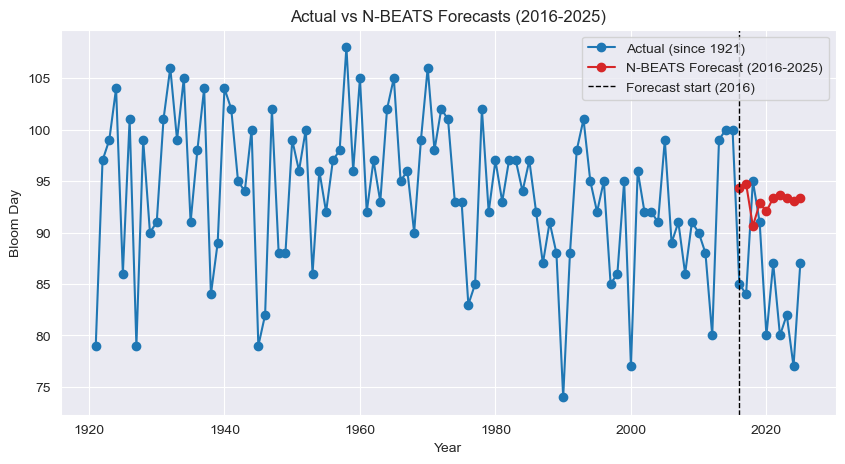

In [125]:
# 7) Plot actuals and forecasts with vertical line at 2016
plt.figure(figsize=(10,5))
plt.plot(df['year'], df['bloom_day'].values, marker='o', color='tab:blue', label='Actual (since 1921)')
if len(test_df) > 0:
    plt.plot(test_df['year'], test_df['pred_bloom_day'].values, marker='o', color='tab:red', label='N-BEATS Forecast (2016-2025)')
    plt.axvline(2016, color='k', linestyle='--', linewidth=1, label='Forecast start (2016)')

plt.xlabel('Year')
plt.ylabel('Bloom Day')
plt.title('Actual vs N-BEATS Forecasts (2016-2025)')
plt.legend()
plt.grid(True)
plt.show()


In [126]:
# End of N-BEATS notebook
